In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_participation = "participation.xlsx"
file_enrollment = 'enrollment.xlsx'

excel_participation = pd.ExcelFile(file_participation)
excel_enrollment = pd.ExcelFile(file_enrollment)

participation = {}
for year in excel_participation.sheet_names: #creates dicts to store each pandas sheet for year ex. participation[2007] gives 2007
    participation[year] = pd.read_excel(file_participation, sheet_name=year, index_col=1, header=None, names=['School', 'Takers', 'Tests', '1', '2', '3', '4', '5+'])
    participation[year].index.names = ['ID']

enrollment = {} 
for year in excel_enrollment.sheet_names:##creates dicts to store each pandas sheet for year
    enrollment[year] = pd.read_excel(excel_enrollment, sheet_name=year, index_col=1, header=None)
    if year!='rankings':
        enrollment[year]['9-12'] = enrollment[year][12]+enrollment[year][13]+enrollment[year][14]+enrollment[year][15]
        enrollment[year].drop([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], axis=1, inplace=True)
        enrollment[year] = enrollment[year][enrollment[year]['9-12'] != 0]
    if year=='rankings':
        enrollment[year].columns = ['School', 'state_rank', 'national_rank']
        enrollment[year] = enrollment[year].dropna()
    enrollment[year].index.names = ['ID']


In [3]:
relatives = {}
for year in excel_participation.sheet_names:
    relatives['enrollment' + year] = pd.DataFrame()
    relatives['takers' + year] = pd.DataFrame()
    relatives['tests' + year] = pd.DataFrame()


In [4]:
participation_reference = {}
years = []
for year in excel_participation.sheet_names:
# if 1>0:
    participation_reference[year] = pd.concat([participation[year]['1'],
                participation[year]['2'],
                participation[year]['3'],
                participation[year]['4'],
                participation[year]['5+']],
                axis=1,)
    participation_reference[year]['4+'] = participation[year]['4'] + participation[year]['5+']
    participation_reference[year]['3+'] = participation[year]['3'] + participation_reference[year]['4+']
    participation_reference[year]['2+'] = participation[year]['2'] + participation_reference[year]['3+']
    participation_reference[year]['1+'] = participation[year]['1'] + participation_reference[year]['2+']
    
    for i in participation_reference[year].columns:
        relatives['enrollment' + year][i] = participation_reference[year][i] / enrollment[year]['9-12'] * 100
        relatives['takers' + year][i] = participation_reference[year][i] / participation[year]['Takers'] * 100
        relatives['tests' + year][i] = participation_reference[year][i] / participation[year]['Tests'] * 100
        relative_to = [relatives['enrollment' + year], relatives['takers' + year], relatives['tests' + year]]
        for x in relative_to:
            x['School'] = participation[year]['School']
            y = pd.DataFrame() ## creates the district column by splitting the school column
            y['a'] = participation[year]['School'].str.split()
            y = y.stack().str[0].unstack()
            x['District'] = y['a']
            x['state_rank'] = enrollment['rankings']['state_rank']
            x['national_rank'] = enrollment['rankings']['national_rank']
        relative_to=None
        y=None


# Utility Functions


In [5]:
def ID_from_district(district): ##self explanatory
    return int(relatives['enrollment2017'][relatives['enrollment2017']['District']==district].index[0])

def ID_from_school(school): ##self explanatory
    return int(relatives['enrollment2017'][relatives['enrollment2017']['School']==school].index[0])

def from_ID(ID, chosen_column):
    return relatives['enrollment2017'].loc[ID, chosen_column]


# Exploratory Functions

In [6]:
def progression(district, relative_choice, chosen_column, start_year, end_year, isID=False,): ##creates pd.series to store changes in years
    if isID!=True:
        school_ID = ID_from_district(district)
    else:
        school_ID = district
    progression = pd.Series()
    for year in range(start_year, end_year):
        progression = progression.append(pd.Series(relatives[relative_choice+str(year)].loc[school_ID, chosen_column], index=[year]))
    return progression

def compare_progression(district1, district2, relative_choice, chosen_column, start_year, end_year, isID=False,):
    s1 = progression(district1, relative_choice, chosen_column, start_year, end_year, isID)
    s2 = progression(district2, relative_choice, chosen_column, start_year, end_year, isID)
    df = pd.concat([s1, s2], axis=1)
    if isID==True:
        df.columns = [from_ID(school1_ID, 'District'), from_ID(school2_ID, 'District')]
    else:
        df.columns = [district1, district2]
    df.plot( kind= 'bar' , secondary_y=1 , rot= 0)
    

        

In [10]:
def top50_progression(relative_choice, chosen_column, start_year, end_year):
    top50 = pd.DataFrame()
    for school in enrollment['rankings']['School']:
        s1 = progression(ID_from_school(school), relative_choice, chosen_column, start_year, end_year, isID=True)
        top50[school] = s1
    return top50  

top50_progression('enrollment', '3+', 2009, 2014)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [381]:
for school in enrollment['rankings']['School']:
    print(school)
    print(ID_from_school(school))

Abby Kelley Foster Charter Public (District) - Abby Kelley Foster Charter Public School


IndexError: index 0 is out of bounds for axis 0 with size 0

# Visualization

### Multi-Year Analysis

In [ ]:

chosen_column = '4+'
index = False

xcolumn = 'District'
if index==True:
    xcolumn = charted.index
charted = charted.sort_values([chosen_column], ascending=False)

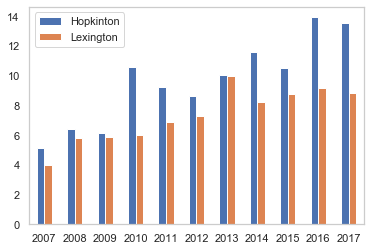

In [253]:
compare_progression('Hopkinton', 'Lexington','enrollment', '3+', 2007, 2018)

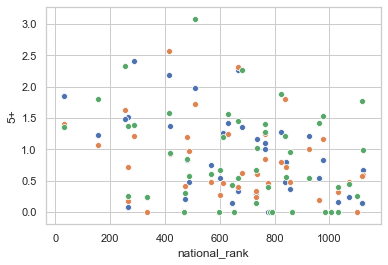

In [270]:
for year in range(2014,2017):
    sns.scatterplot(x="national_rank", y='5+', data=relatives['enrollment'+str(year)], legend='full')
plt.show()


# sns.scatterplot(x="national_rank", y='4+', data=charted)
# plt.show()

# sns.scatterplot(x="national_rank", y='5+', data=charted)
# plt.show()

### Specific-Year Analysis
Setup for many of the next cells

In [361]:
charted = relatives['enrollment2016']
chosen_column = '4+'
index = False

xcolumn = 'District'
if index==True:
    xcolumn = charted.index
charted = charted.sort_values([chosen_column], ascending=False)


In [362]:
charted.drop(['1', 'School', 'District','national_rank', '2', '3', '4', '5+', '2+'], axis=1, inplace=True)
# charted['ID_label'] = charted.index
charted = pd.melt(charted, id_vars=['state_rank'], value_vars=['3+','4+'])
charted = charted.sort_values(['value'], ascending=False)

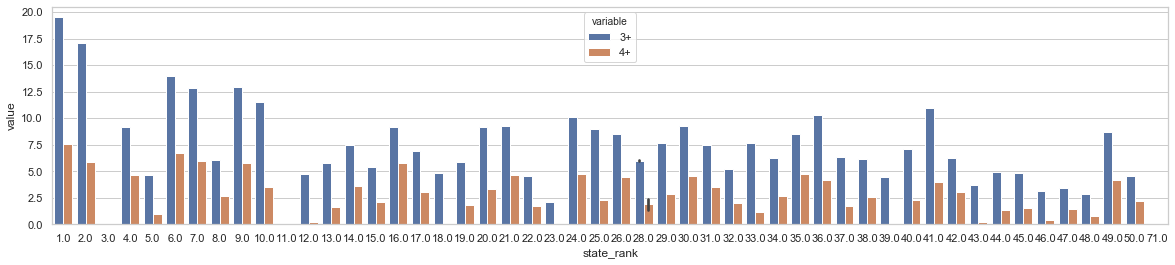

In [363]:
sns.set(style="whitegrid")
plt.subplots(figsize=(20,4))
sns.barplot(x='state_rank', y='value', hue='variable', data=charted)
plt.show()

#### Barplot

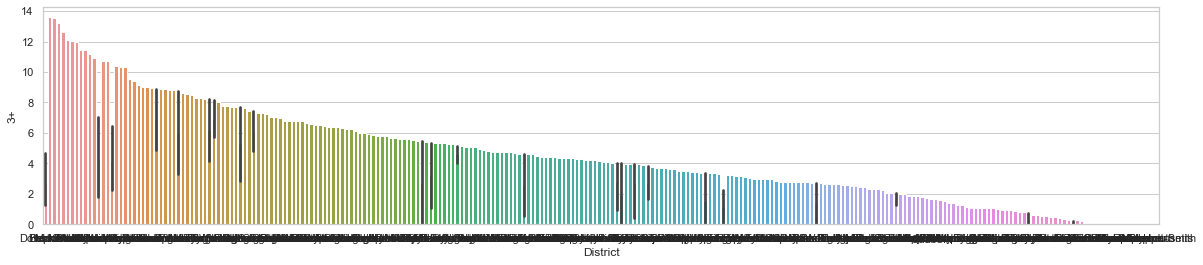

In [186]:
# charted = charted.head(10)
sns.set(style="whitegrid")
plt.subplots(figsize=(20,4))
sns.barplot(x=xcolumn, y=chosen_column, data=charted)
plt.show()

Rank-Based Barplot

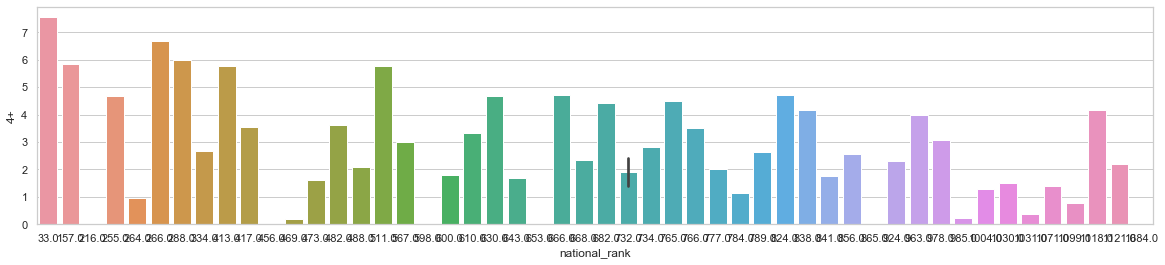

In [306]:
sns.set(style="whitegrid")
plt.subplots(figsize=(20,4))
sns.barplot(x='national_rank', y=chosen_column, data=charted)
plt.show()

#### KDE Plot

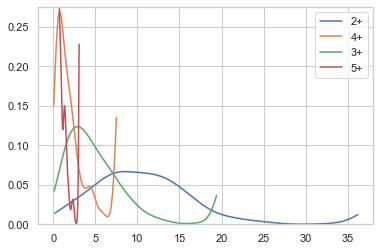

In [302]:
cut_number = -.1
sns.kdeplot(charted['2+'], cut=cut_number)
sns.kdeplot(charted['4+'], cut=cut_number)
sns.kdeplot(charted['3+'], cut=cut_number)
sns.kdeplot(charted['5+'], cut=cut_number)
plt.ylim(0, .275)
plt.show()